In [44]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from mobius import VirtualTarget, ForceField

In [67]:
def plot_logbook(logbook, minimum_score):
    gen = logbook.select("gen")
    fit_mins = logbook.select("min")
    size_avgs = logbook.select("avg")

    fig, ax1 = plt.subplots(figsize=(15, 5))
    line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")
    
    line3 = ax1.plot(np.linspace(0, np.max(gen), np.max(gen)), [minimum_score] * np.max(gen), 
             '--', color='green', label='Target fitness')

    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, size_avgs, "r-", label="Average Fitness")
    ax2.set_ylabel("Size", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")

    lns = line1 + line2 + line3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="upper right")
    
    ax1.set_ylim([0, 12])
    ax2.set_ylim([0, 20])

    plt.show()
    

def plot_distribution(logbooks, variable_name, x_labels, min_score=None, fig_name=None):
    i = 0
    max_gen = np.max(logbooks['gen']) + 1
    n_col = len(set(logbooks[variable_name]))
    
    fig, axarr = plt.subplots(1, n_col, figsize=(n_col*6, 12), sharey=True)

    axarr[0].set_ylabel('#Generations', fontsize=30)
    axarr[0].set_yticks(np.arange(0, max_gen + 1, 1.0))
    axarr[0].tick_params(axis='both', which='major', labelsize=20)

    for _, var_group in logbooks.groupby(variable_name):
        gens = []
        failed = 0

        for _, group in var_group.groupby('run'):
            best = group.sort_values(by=['min', 'gen']).iloc[0]
            if min_score is None:
                gen = best['gen'] + 1 if best['min'] <= group['target_score'].values[0] else max_gen
            else:
                gen = best['gen'] + 1 if best['min'] <= min_score else max_gen
            gens.append(gen)

            if gen == max_gen:
                failed += 1

        sns.set_theme(style=None)
        sns.violinplot(y=gens, cut=0, ax=axarr[i])
        sns.stripplot(y=gens, color='black', size=10, ax=axarr[i])
        axarr[i].set_ylim([-0.5, max_gen + .5])
        axarr[i].set_xlabel('%s - (F: %d)' % (x_labels[i], failed), fontsize=30)

        i += 1
    
    if fig_name is not None:
        plt.savefig(fig_name, dpi=300, bbox_inches='tight')

    plt.show()

# Standard PBIL

In [11]:
class PBIL(object):
    def __init__(self, peptide_length, population_size=96, n_best=1,
                 learning_rate=0.3, mut_prob=0.1, mut_shift=0.05, seed=None):
        self._AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                     'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
        # Random generation
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

        # Initialize probability vectors
        n_amino_acids = len(self._AA1)
        self._peptide_length = peptide_length
        init_probability = 1. / n_amino_acids
        self._prob_vector = np.zeros(shape=(peptide_length, n_amino_acids)) + init_probability

        # PBIL parameters
        self._n_best = n_best
        self._learning_rate = learning_rate
        self._mut_prob = mut_prob
        self._mut_shift = mut_shift
        self._population_size = population_size

    def sample(self):
        ind = [self._rng.choice(self._AA1, p=self._prob_vector[i]) for i in range(self._peptide_length)]
        return (ind)

    def generate(self, ind_init):
        return [ind_init(self.sample()) for _ in range(self._population_size)]

    def update(self, population, scores=None):
        if scores is None:
            scores = np.array([ind.fitness.values[0] for ind in population])

        best_peptide_indices = np.argsort(np.ravel(scores))[:self._n_best]
        best_peptides = np.array(population)[best_peptide_indices]
        
        for i in range(self._peptide_length):
            if self._n_best > 1:
                unique_amino_acids, counts = np.unique(best_peptides[:,i], return_counts=True)
                frequencies = counts / np.sum(counts)
            else:
                unique_amino_acids = [best_peptides[0][i]]
                frequencies = [1.]
            
            for unique_amino_acid, frequency in zip(unique_amino_acids, frequencies):
                j = self._AA1.index(unique_amino_acid)
                
                # Update the probability vector (exploitation)
                self._prob_vector[i, j] *= 1.0 - self._learning_rate
                self._prob_vector[i, j] += frequency * self._learning_rate

                # Mutate the probability vector (exploration)
                if self._rng.uniform() < self._mut_prob:
                    self._prob_vector[i, j] *= 1.0 - self._mut_shift
                    self._prob_vector[i, j] += self._rng.uniform() * self._mut_shift
            
            # Normalize vector
            self._prob_vector[i] /= np.sum(self._prob_vector[i])


def evaluate(individual):
    return vt.score_peptides([''.join(individual)])[0],

# Initial tests

In [4]:
NLEN = 6

ff = ForceField()
vt = VirtualTarget(ff)
vt.generate_random_target_sequence(NLEN)
vt.generate_pharmacophore_from_target_sequence('AAAAAA', solvent_exposures=[0] * 6)
print(vt.target_sequence())
print(vt.score_peptides([vt.target_sequence()]))
minimum_score = vt.score_peptides([vt.target_sequence()])[0]

AAAAAA
[0.]


## Not initialized with a known sequence

gen	nevals	avg    	std    	min    	max    
0  	96    	16.4734	3.37263	8.30979	23.9529
1  	96    	14.3046	3.60991	6.67916	23.9442
2  	96    	11.7751	3.02956	4.14775	17.8652
3  	96    	10.0551	3.62733	1.61866	18.7614
4  	96    	7.58073	3.25491	1.61866	16.4768
5  	96    	6.80719	3.22677	1.61866	16.3899
6  	96    	6.13134	2.74432	1.61866	12.5248
7  	96    	5.01569	2.93876	1.61866	13.3124
8  	96    	5.07469	2.99717	1.61866	16.2864
9  	96    	4.75226	2.57657	1.61866	15.8581


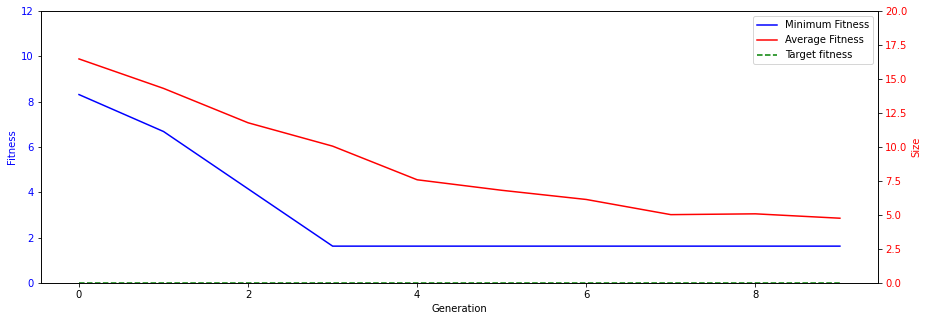

[['P', 'A', 'P', 'A', 'P', 'A'], ['P', 'A', 'P', 'G', 'A', 'A'], ['P', 'A', 'G', 'A', 'P', 'A'], ['G', 'A', 'P', 'A', 'P', 'A'], ['P', 'A', 'P', 'A', 'G', 'A'], ['P', 'A', 'P', 'A', 'P', 'G'], ['P', 'G', 'P', 'A', 'P', 'A'], ['P', 'A', 'P', 'G', 'P', 'A'], ['P', 'A', 'P', 'G', 'G', 'A'], ['P', 'A', 'G', 'G', 'P', 'A']]


In [5]:
NGEN = 10
NIND = 96

#Initialize the PBIL EDA
pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=1, learning_rate=0.5, mut_prob=0.00, mut_shift=0.05)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)
toolbox.register("generate", pbil.generate, creator.Individual)
toolbox.register("update", pbil.update)

# Statistics computation
hof = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=True, halloffame=hof)

plot_logbook(logbook, minimum_score)

print(hof.items)

## Initialized with a known sequence

8.4407425
gen	nevals	avg    	std    	min    	max    
0  	96    	13.4956	3.29945	4.59812	20.2578
1  	96    	10.6505	3.61909	2.55444	18.7581
2  	96    	7.90442	3.36511	2.55444	18.5956


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


3  	96    	7.71951	3.2558 	2.55444	15.6173
4  	96    	6.35808	2.84169	2.55444	15.9958
5  	96    	5.98951	2.87528	0.539552	13.314 
6  	96    	4.8638 	2.88781	0.539552	14.8336
7  	96    	3.82204	2.76255	0.539552	14.5752
8  	96    	3.65133	3.043  	0.539552	12.1516
9  	96    	3.27618	2.83302	0.539552	15.8972


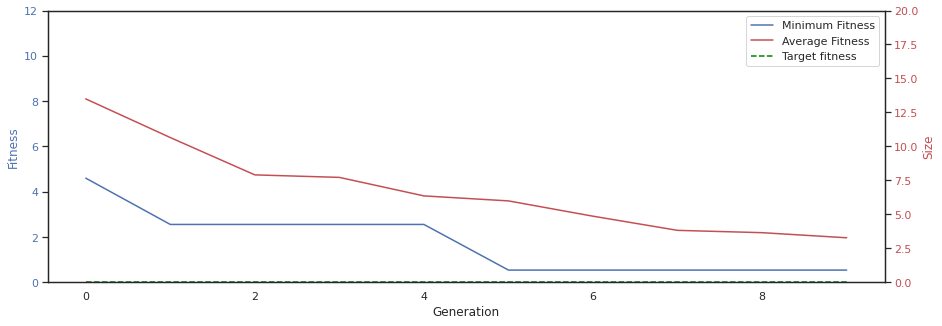

[['A', 'A', 'A', 'P', 'A', 'A'], ['A', 'A', 'A', 'G', 'A', 'A'], ['P', 'A', 'A', 'P', 'A', 'A'], ['A', 'P', 'A', 'P', 'A', 'A'], ['A', 'A', 'A', 'P', 'P', 'A'], ['A', 'A', 'A', 'P', 'G', 'A'], ['A', 'A', 'A', 'G', 'A', 'P'], ['A', 'A', 'A', 'P', 'A', 'G'], ['M', 'A', 'A', 'A', 'A', 'A'], ['A', 'A', 'A', 'L', 'A', 'A']]


In [323]:
NGEN = 10
NIND = 96

#Initialize the PBIL EDA
pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=1, learning_rate=0.6, mut_prob=0.00, mut_shift=0.05)

# Incorporate known data
individuals = vt.generate_random_peptides_from_target_sequence(1, minimum_mutations=3, maximum_mutations=3)
scores = vt.score_peptides(individuals)
print(np.min(scores))
pbil.update([list(ind) for ind in individuals], scores)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)
toolbox.register("generate", pbil.generate, creator.Individual)
toolbox.register("update", pbil.update)

# Statistics computation
hof = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=True, halloffame=hof)

plot_logbook(logbook, minimum_score)

print(hof.items)

# Effect of the number of mutations (from the target sequence)

## Repetitive peptide sequence

In [22]:
NLEN = 6
target_sequence = 'AAAAAA'

ff = ForceField()
vt = VirtualTarget(ff)
#vt.generate_random_target_sequence(NLEN)
vt.generate_pharmacophore_from_target_sequence(target_sequence, solvent_exposures=[0] * 6)
target_sequence = vt.target_sequence()
print(vt.target_sequence())
print(vt.score_peptides([vt.target_sequence()]))
target_sequence = vt.target_sequence()
min_score = vt.score_peptides([vt.target_sequence()])[0]

AAAAAA
[0.]


In [16]:
NGEN = 20
NIND = 96

logbooks = []

for param in range(1, len(target_sequence) + 1):
    print('%s:' % param, end=' ')

    for i in range(100):
        print(i + 1, end=' ')

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=1, learning_rate=0.5, mut_prob=0.05, mut_shift=0.05)

        # Incorporate known data
        individuals = vt.generate_random_peptides_from_target_sequence(1, minimum_mutations=param, 
                                                                       maximum_mutations=param)
        scores = vt.score_peptides(individuals)
        #print(np.min(scores))
        pbil.update([list(ind) for ind in individuals], scores)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['mutations'] = param
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

2: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

3: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

4: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 3

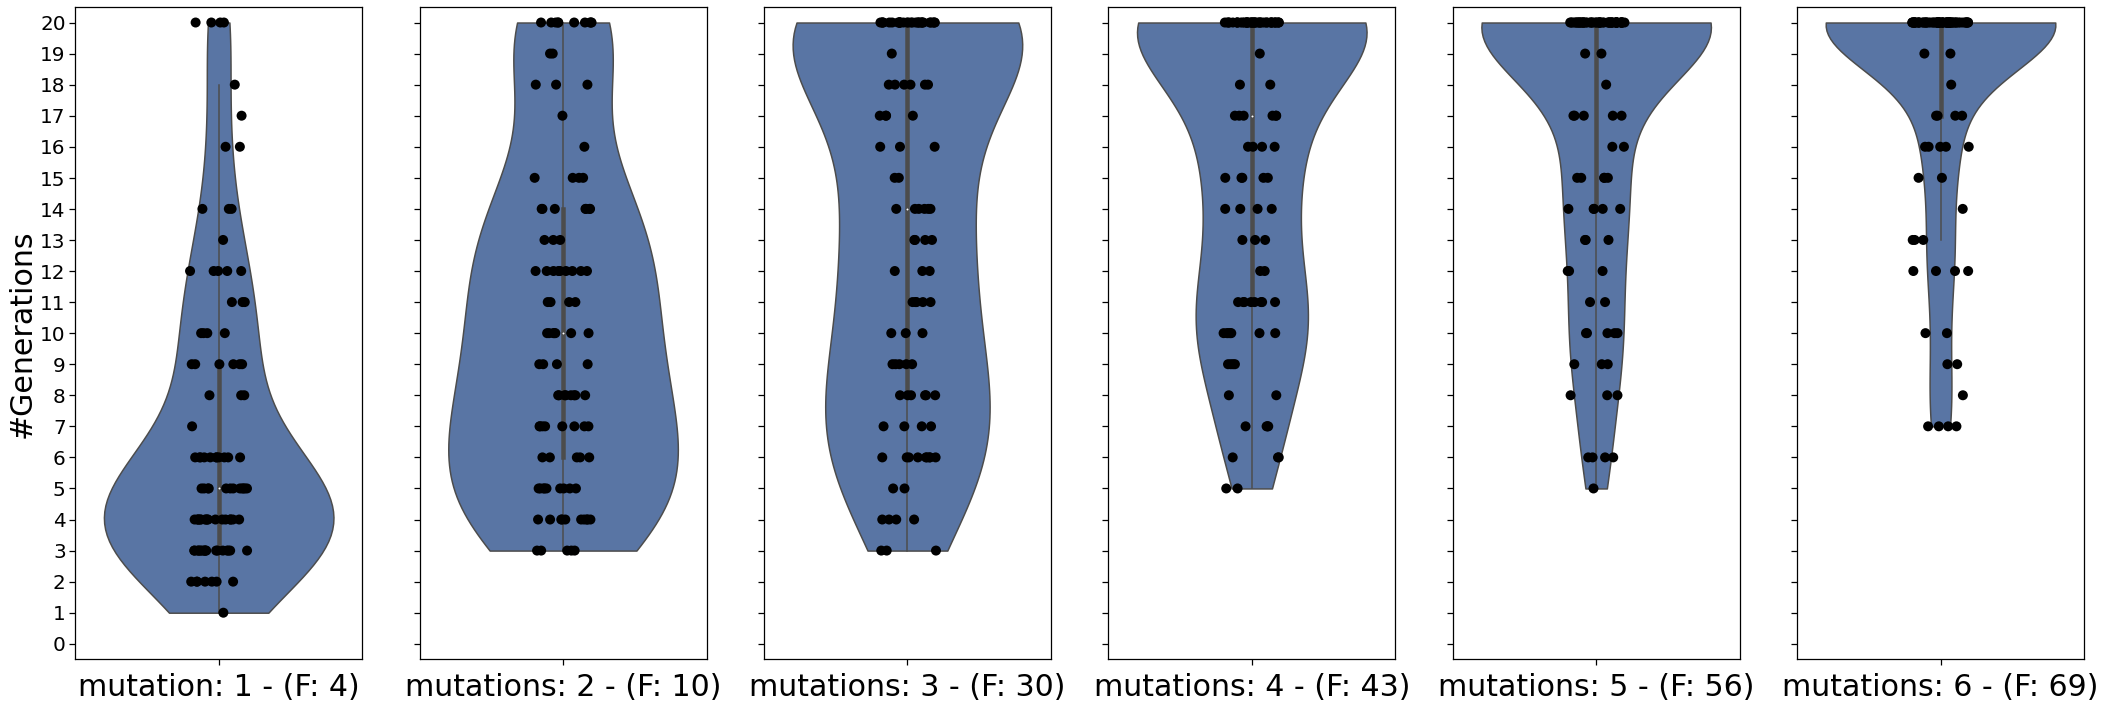

In [52]:
x_labels = ['mutation: 1'] + ['mutations: %d' % i for i in range(2, 7)]
plot_distribution(logbooks, 'mutations', min_score, x_labels, 'figure_peptide_AAAAAA_mutations.png')

## Motif peptide sequence

In [232]:
NLEN = 6
target_sequence = 'KRKRKR'

ff = ForceField()
vt = VirtualTarget(ff)
#vt.generate_random_target_sequence(NLEN)
vt.generate_pharmacophore_from_target_sequence(target_sequence, solvent_exposures=[0] * 6)
target_sequence = vt.target_sequence()
print(vt.target_sequence())
print(vt.score_peptides([vt.target_sequence()]))
target_sequence = vt.target_sequence()
min_score = vt.score_peptides([vt.target_sequence()])[0]

KRKRKR
[0.]


In [55]:
NGEN = 20
NIND = 96

logbooks = []

for param in range(1, len(target_sequence) + 1):
    print('%s:' % param, end=' ')

    for i in range(100):
        print(i + 1, end=' ')

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=1, learning_rate=0.5, mut_prob=0.05, mut_shift=0.05)

        # Incorporate known data
        individuals = vt.generate_random_peptides_from_target_sequence(1, minimum_mutations=param, 
                                                                       maximum_mutations=param)
        scores = vt.score_peptides(individuals)
        #print(np.min(scores))
        pbil.update([list(ind) for ind in individuals], scores)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['mutations'] = param
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

2: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

3: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

4: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 3

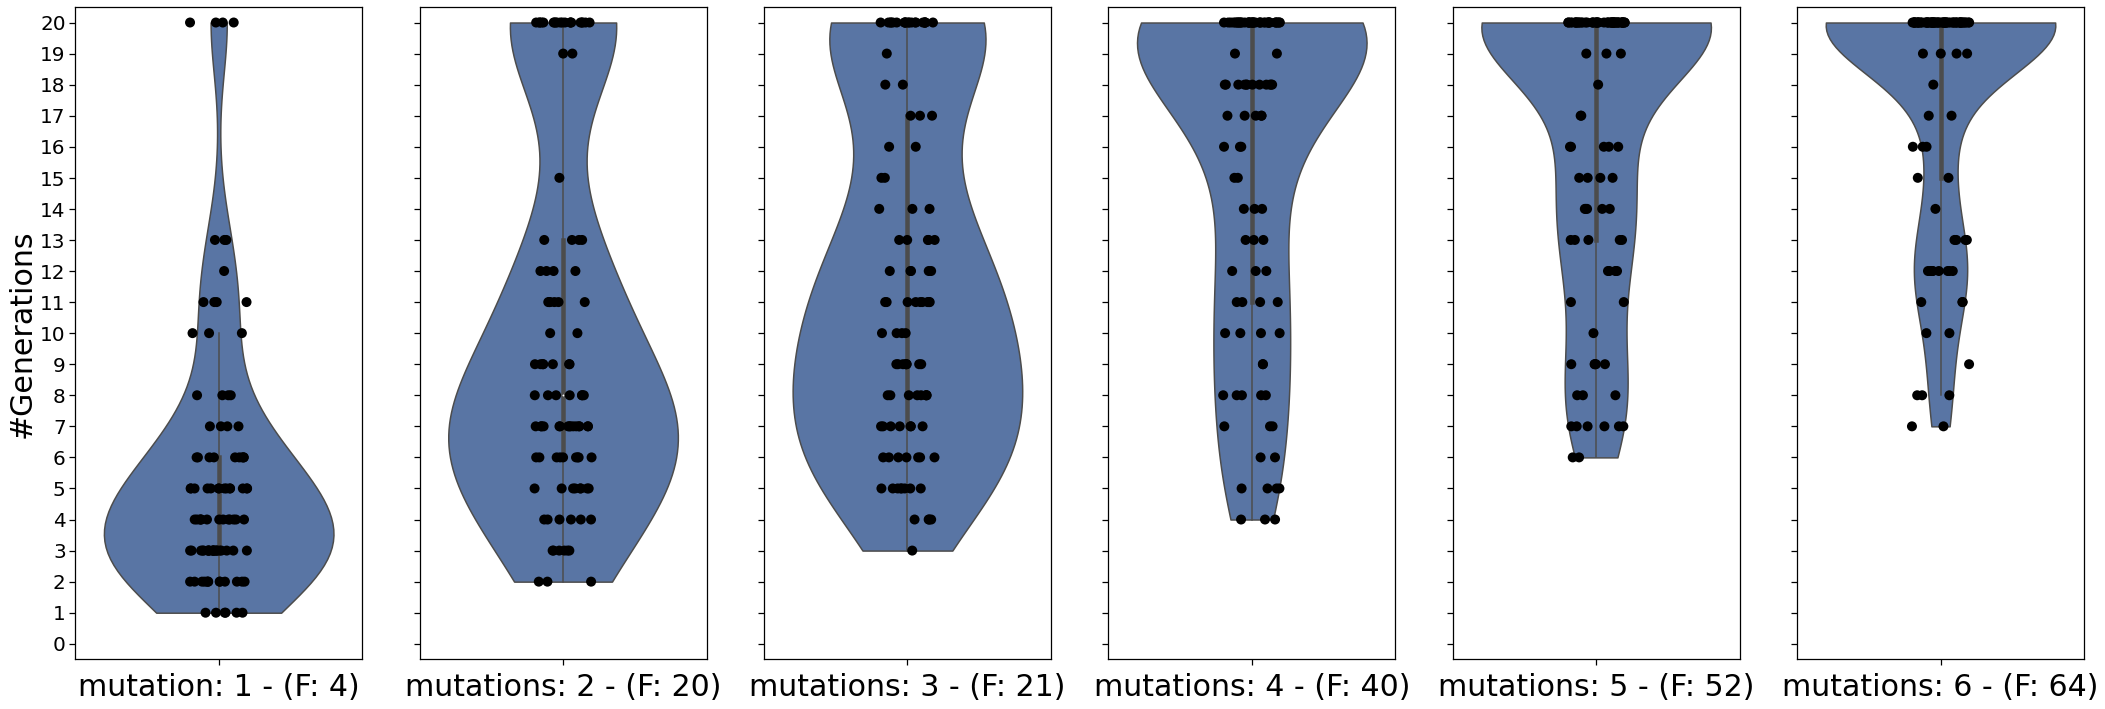

In [56]:
x_labels = ['mutation: 1'] + ['mutations: %d' % i for i in range(2, 7)]
plot_distribution(logbooks, 'mutations', min_score, x_labels, 'figure_peptide_KRKRKR_mutations.png')

## Random peptide sequence

In [57]:
NLEN = 6

ff = ForceField()
vt = VirtualTarget(ff)
vt.generate_random_target_sequence(NLEN)
#vt.generate_pharmacophore_from_target_sequence(target_sequence, solvent_exposures=[0] * 6)
target_sequence = vt.target_sequence()
target_score = vt.score_peptides([vt.target_sequence()])[0]
print(target_sequence)
print(target_score)
target_sequence = vt.target_sequence()
min_score = vt.score_peptides([vt.target_sequence()])[0]

DWLRFV
0.20671687


In [59]:
NGEN = 20
NIND = 96

logbooks = []

for param in range(1, len(target_sequence) + 1):
    print('%s:' % param, end=' ')

    for i in range(100):
        print(i + 1, end=' ')

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=1, learning_rate=0.5, mut_prob=0.05, mut_shift=0.05)

        # Incorporate known data
        individuals = vt.generate_random_peptides_from_target_sequence(1, minimum_mutations=param, 
                                                                       maximum_mutations=param)
        scores = vt.score_peptides(individuals)
        #print(np.min(scores))
        pbil.update([list(ind) for ind in individuals], scores)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['mutations'] = param
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

2: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

3: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

4: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 3

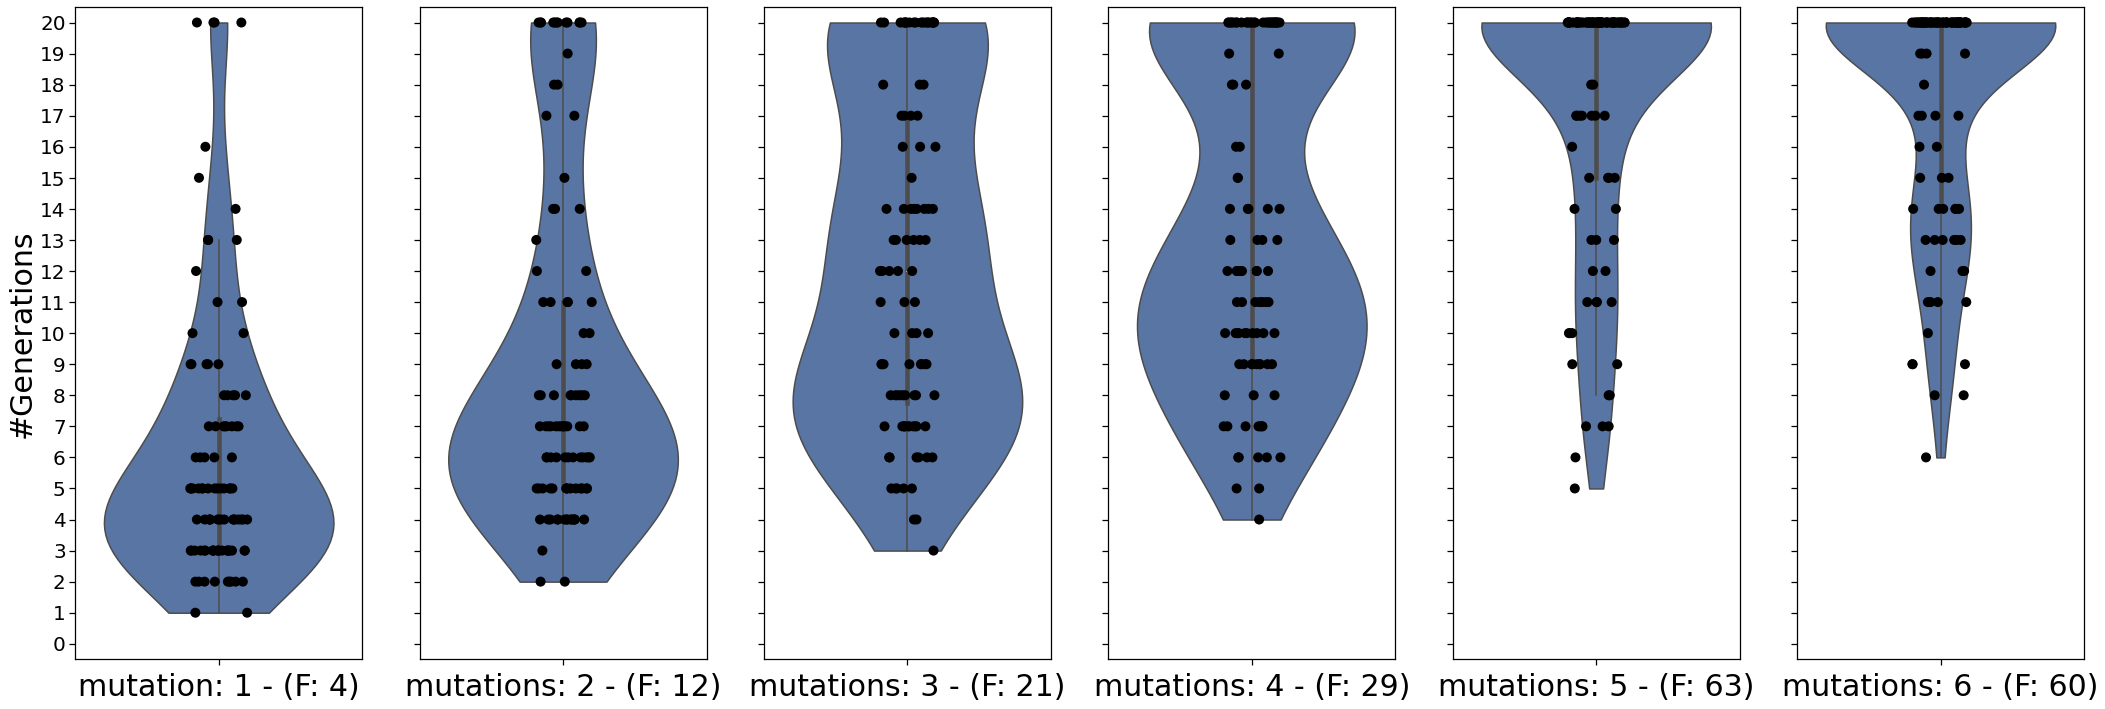

In [60]:
x_labels = ['mutation: 1'] + ['mutations: %d' % i for i in range(2, 7)]
plot_distribution(logbooks, 'mutations', min_score, x_labels, 'figure_peptide_%s_mutations.png' % target_sequence)

## Effect of the peptide length

In [71]:
NGEN = 20
NIND = 96

logbooks = []

ff = ForceField()
vt = VirtualTarget(ff)

for param in [4, 6, 8, 10, 12, 14]:
    print('%s:' % param, end=' ')

    for i in range(100):
        print(i + 1, end=' ')
        
        vt.generate_random_target_sequence(param)
        target_sequence = vt.target_sequence()
        target_score = vt.score_peptides([vt.target_sequence()])[0]

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=param, population_size=NIND, n_best=1, learning_rate=0.5, mut_prob=0.05, mut_shift=0.05)

        # Incorporate known data
        individuals = vt.generate_random_peptides_from_target_sequence(1, minimum_mutations=int(param/2),
                                                                       maximum_mutations=int(param/2))
        scores = vt.score_peptides(individuals)
        pbil.update([list(ind) for ind in individuals], scores)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['length'] = param
        df['target_score'] = target_score
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

4: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

6: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

8: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

10: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 

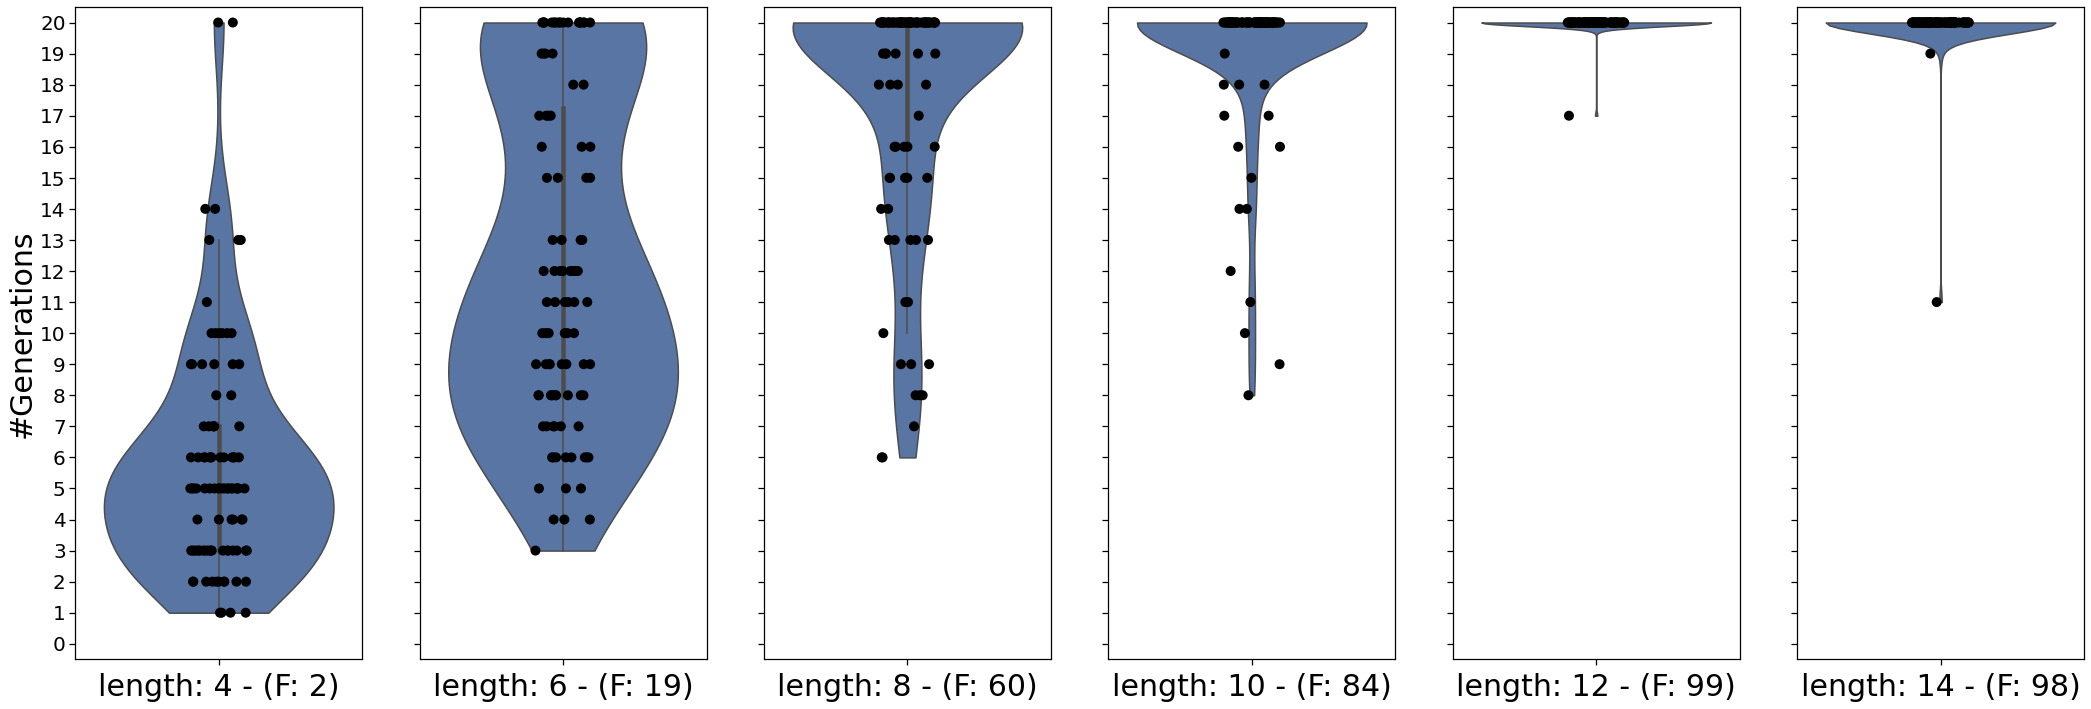

In [72]:
x_labels = ['length: %d' % i for i in [4, 6, 8, 10, 12, 14]]
plot_distribution(logbooks, 'length', x_labels, None, 'figure_peptide_length.png')

In [76]:
NGEN = 20
NIND = 96

logbooks = []

ff = ForceField()
vt = VirtualTarget(ff)

for param in [4, 6, 8, 10, 12, 14]:
    print('%s:' % param, end=' ')

    for i in range(100):
        print(i + 1, end=' ')
        
        vt.generate_random_target_sequence(param)
        target_sequence = vt.target_sequence()
        target_score = vt.score_peptides([vt.target_sequence()])[0]

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=param, population_size=NIND, n_best=1, learning_rate=0.5, mut_prob=0.05, mut_shift=0.05)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['length'] = param
        df['target_score'] = target_score
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

4: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

6: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

8: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

10: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 

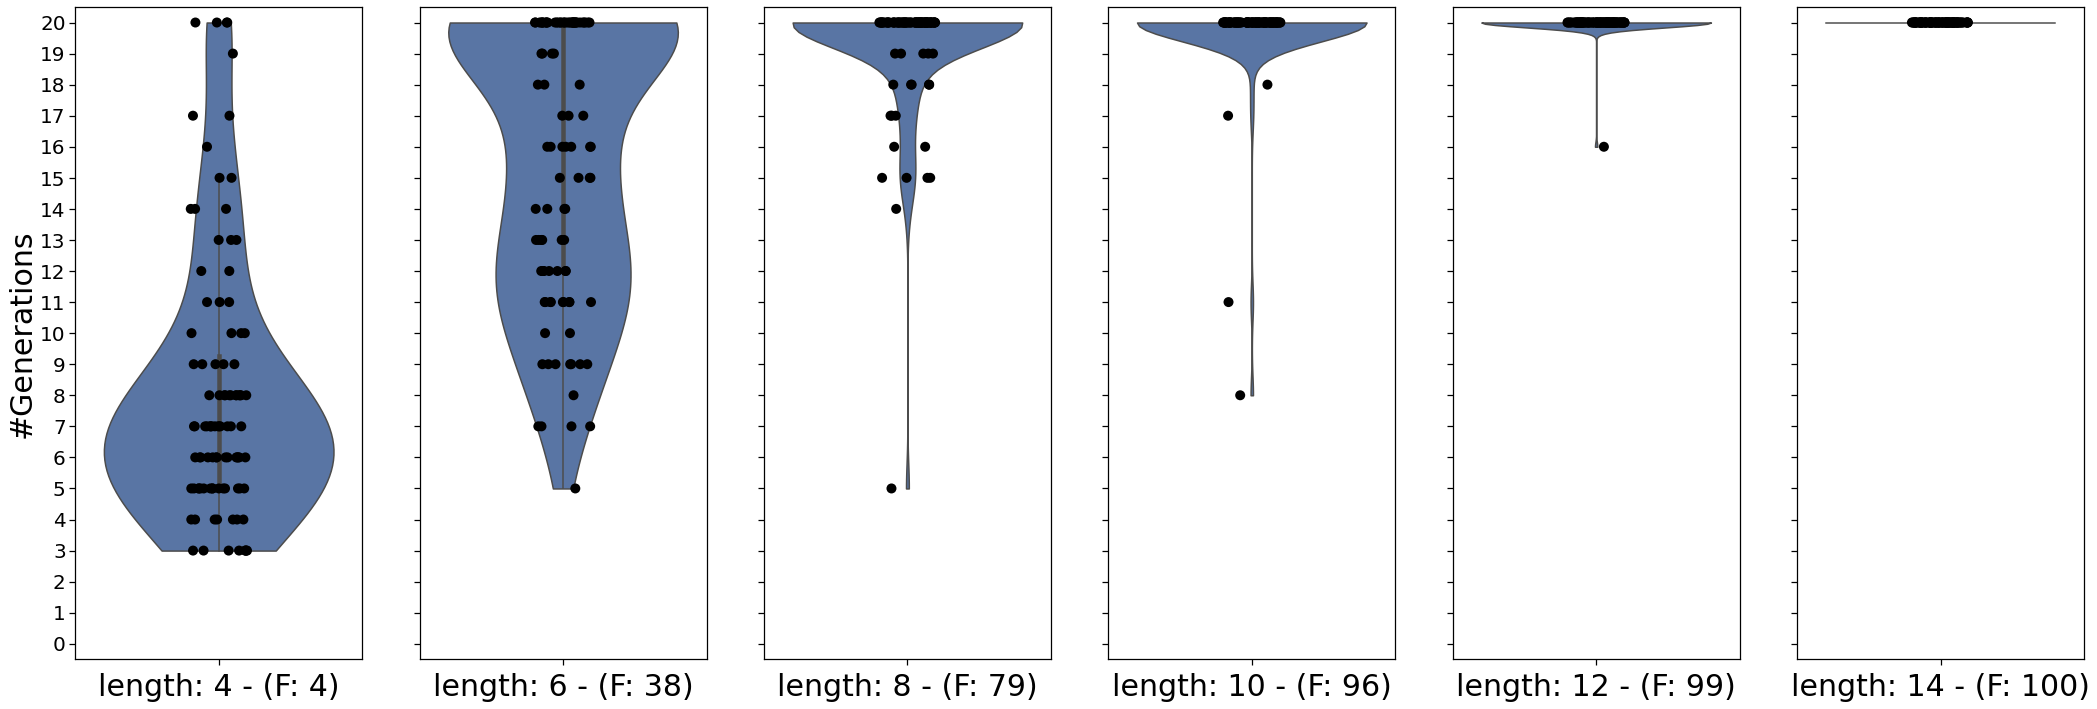

In [77]:
x_labels = ['length: %d' % i for i in [4, 6, 8, 10, 12, 14]]
plot_distribution(logbooks, 'length', x_labels, None, 'figure_peptide_length_nowarmup.png')

## Effect of the learning rate

In [73]:
NGEN = 20
NIND = 96
NLEN = 8

ff = ForceField()
vt = VirtualTarget(ff)

logbooks = []

for param in [0.2, 0.4, 0.6, 0.8, 1.0]:
    print('%s:' % param, end=' ')

    for i in range(100):
        print(i + 1, end=' ')
        
        vt.generate_random_target_sequence(NLEN)
        target_sequence = vt.target_sequence()
        target_score = vt.score_peptides([vt.target_sequence()])[0]

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=1, learning_rate=param, mut_prob=0.05, mut_shift=0.05)

        # Incorporate known data
        individuals = vt.generate_random_peptides_from_target_sequence(1, minimum_mutations=4, maximum_mutations=4)
        scores = vt.score_peptides(individuals)
        #print(np.min(scores))
        pbil.update([list(ind) for ind in individuals], scores)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['learning_rate'] = param
        df['target_score'] = target_score
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

0.2: 1 

/home/eberhardt/Applications/miniconda3/envs/mm/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eberhardt/Applications/miniconda3/envs/mm/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

0.4: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

0.6: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

0.8: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 

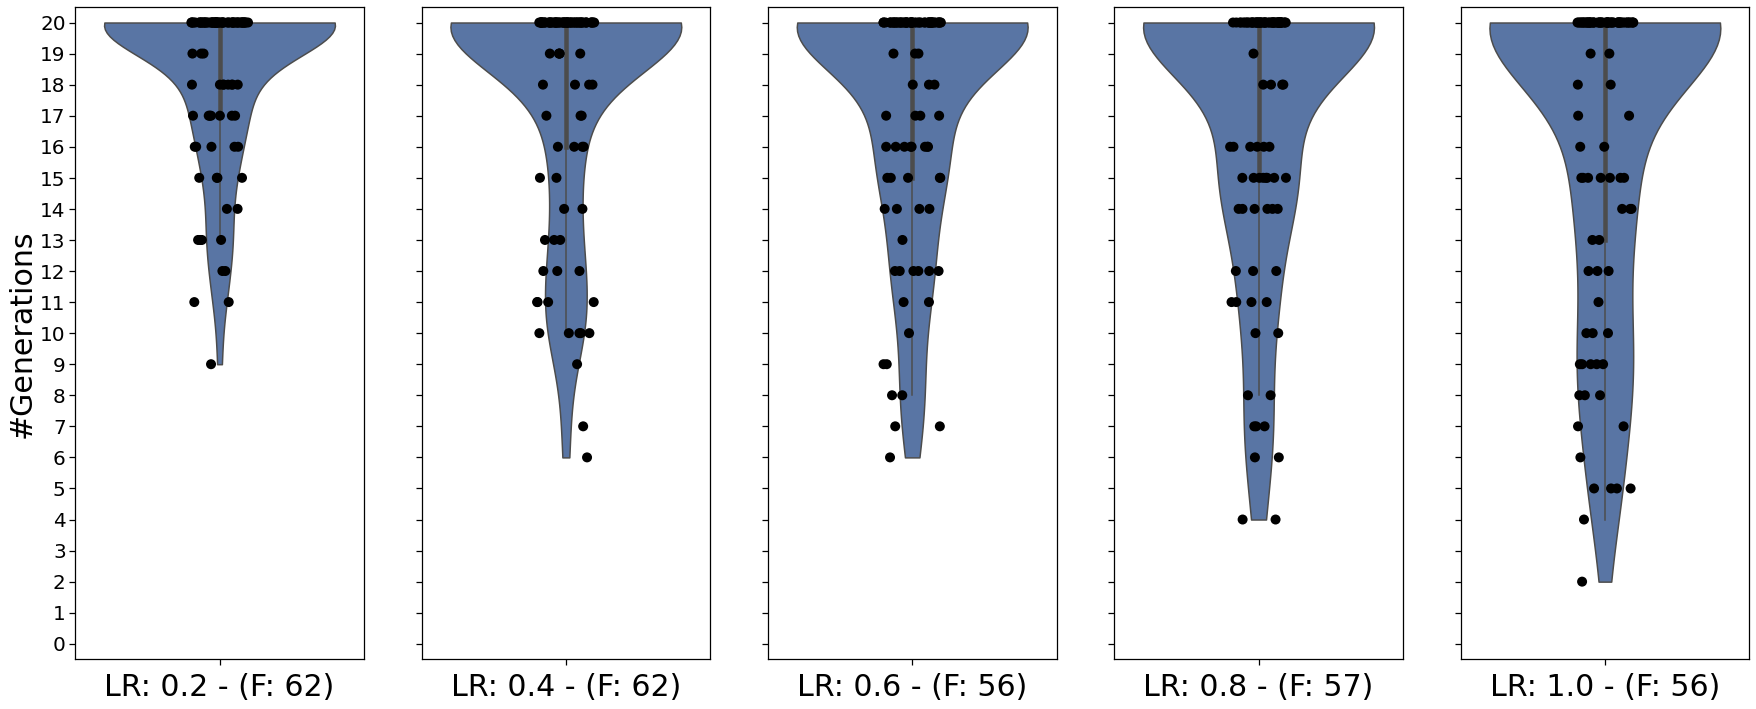

In [74]:
x_labels = ['LR: %.1f' % i for i in [0.2, 0.4, 0.6, 0.8, 1.0]]
plot_distribution(logbooks, 'learning_rate', x_labels, None, 'figure_peptide_learning_rate.png')